# Предсказание данных **MNIST**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader
import torch
import pytorch_lightning as pl
import struct
from array import array

import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
    
from models.pl_model import NeuralNetworkPL
from datasets.dataset import CustomDataset

### Подготовка данных

In [3]:
class MnistDataloader:
    def __init__(self, training_images_filepath, training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath

    def read_images_labels(self, images_path, labels_path):
        with open(labels_path, 'rb') as label_file:
            magic, size = struct.unpack(">II", label_file.read(8))
            if magic != 2049:
                raise ValueError(f'Magic number mismatch in labels. Got {magic}, expected 2049')
            labels = array("B", label_file.read())

        with open(images_path, 'rb') as image_file:
            magic, size, rows, cols = struct.unpack(">IIII", image_file.read(16))
            if magic != 2051:
                raise ValueError(f'Magic number mismatch in images. Got {magic}, expected 2051')
            image_data = array("B", image_file.read())

        images = []
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols]).reshape(rows, cols)
            images.append(img)

        return np.array(images), np.array(labels)

    def load_data(self):
        X_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        X_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (X_train, y_train), (X_test, y_test)


training_images_filepath = '../data/mnist-dataset/train-images.idx3-ubyte'
training_labels_filepath = '../data/mnist-dataset/train-labels.idx1-ubyte'
test_images_filepath = '../data/mnist-dataset/t10k-images.idx3-ubyte'
test_labels_filepath = '../data/mnist-dataset/t10k-labels.idx1-ubyte'

mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath,
                                   test_images_filepath, test_labels_filepath)
(X_train, y_train), (X_test, y_test) = mnist_dataloader.load_data()

X_train = np.array([np.ravel(x) for x in X_train], dtype=np.float32) / 255.0
X_test = np.array([np.ravel(x) for x in X_test], dtype=np.float32) / 255.0

X_train_val, X_test = X_train, X_test
y_train_val, y_test = y_train, y_test

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42
)

def one_hot(a, num_classes):
    return np.eye(num_classes)[a]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, persistent_workers=True)

### Обучение модели

In [4]:
input_size = X_train.shape[1]  
output_size = len(np.unique(y_train))

model = NeuralNetworkPL(
    input_size=input_size,
    hidden_sizes=[100, 200],
    output_size=output_size,
    activation='relu',
    task='classification'
)

trainer = pl.Trainer(max_epochs=50, accelerator="auto", log_every_n_steps=10)
trainer.fit(model, train_loader, val_loader)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 100 K  | train
--------------------------------------------
100 K     Trainable params
0         Non-trainable params
100 K     Total params
0.403     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 750/750 [00:04<00:00, 165.17it/s, v_num=21]     

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 750/750 [00:04<00:00, 164.88it/s, v_num=21]


### Тестирование

In [5]:
trainer.test(model, dataloaders=test_loader)\
    
def predict(model, data_loader):
    model.eval()
    all_preds = []
    with torch.no_grad():
        for X_batch, _ in data_loader:
            logits = model(X_batch)
            probs = torch.softmax(logits, dim=1)
            all_preds.append(probs.numpy())
    return np.concatenate(all_preds)

y_pred_probs = predict(model, test_loader)

Testing DataLoader 0: 100%|██████████| 157/157 [00:00<00:00, 429.09it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     1.047623872756958     │
└───────────────────────────┴───────────────────────────┘

In [6]:
from sklearn.metrics import accuracy_score

y_pred_classes = np.argmax(y_pred_probs, axis=1)

accuracy = accuracy_score(y_test, y_pred_classes)
print(f"Точность модели на тестовой выборке: {accuracy * 100:.2f}%")

Точность модели на тестовой выборке: 92.15%


### Визуализация

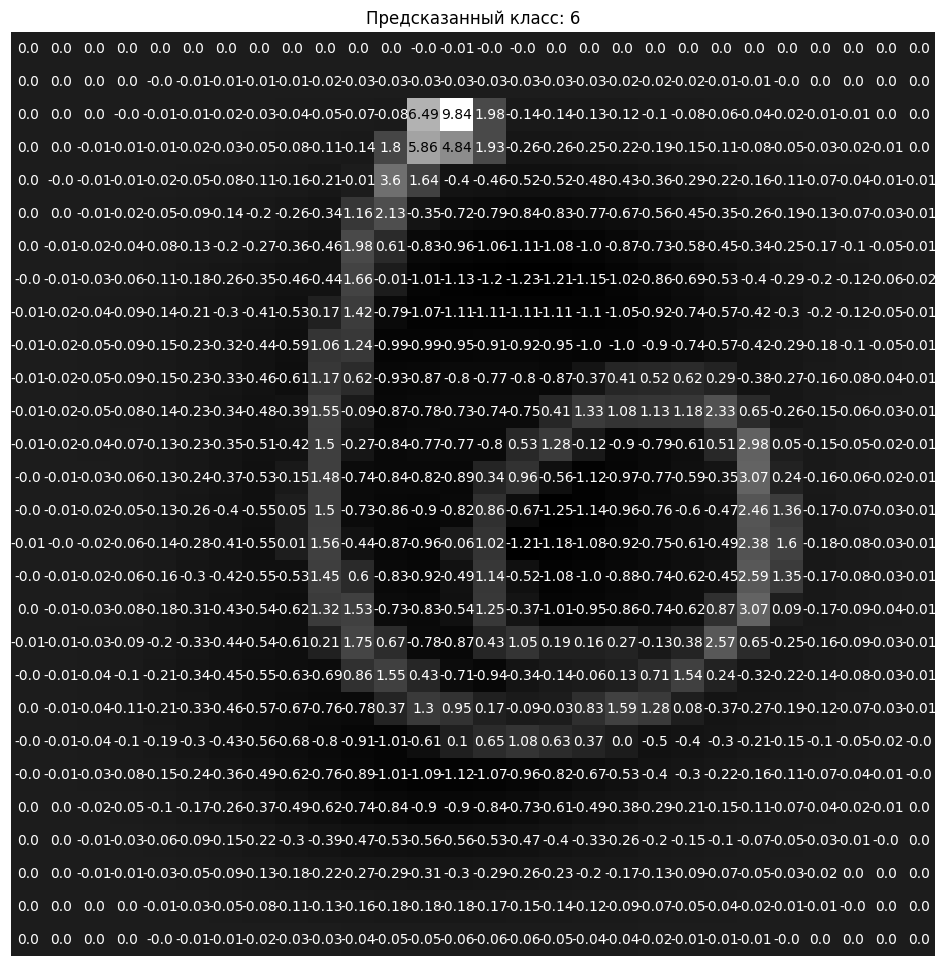

In [7]:
def visualize_input(img, ax):
    img_reshaped = img.reshape(28, 28)
    ax.imshow(img_reshaped, cmap='gray')
    width, height = img_reshaped.shape
    thresh = img_reshaped.max() / 2.5
    for x in range(width):
        for y in range(height):
            ax.annotate(str(round(img_reshaped[x][y], 2)), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if img_reshaped[x][y] < thresh else 'black')

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
visualize_input(X_test[100], ax)
plt.title(f"Предсказанный класс: {np.argmax(y_pred_probs[100])}")
plt.axis('off')
plt.show()